<a href="https://colab.research.google.com/github/wei-jun7/Project-MI-and-AI/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part1. In this part you will implement a neural network from scratch. You cannot use any existing
Deep Learning Framework. You can utilize NumPy and Pandas libraries to perform efficient
calculations. Refer to Lecture 5 slides for details on computations required.
Write a Class called NeuralNetwork that has at least the following methods (you are free to add
your own methods too):

a. Initialization method.

b. Forward propagation method that performs forward propagation calculations.

c. Backward propagation method that implements the backpropagation algorithm
discussed in class.

d. Train method that includes the code for gradient descent.

e. Cost method that calculates the loss function.

f. Predict method that calculates the predictions for the test set.

Test your NeuralNetwork Class with the dataset you selected. If the dataset is big, you may
notice inefficiencies in runtime. Try incorporating different versions of gradient descent to
improve that (Minibatch, Stochastic etc.). You may choose to use only a subset of your data for
this task (or any other technique). Explain which technique you followed and why.



Dataset come from https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix as sk_confusion_matrix


class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.weights, self.biases = self.init_weight_bias(layer_sizes)

    def init_weight_bias(self, layer_sizes):
        next_layer_sizes = layer_sizes[1:]
        weights = [np.random.randn(size_in, size_out) * np.sqrt(2. / size_in) for size_in, size_out in zip(layer_sizes, next_layer_sizes)]
        biases = [np.random.randn(1, size) for size in next_layer_sizes]
        return weights, biases

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / exp_z.sum(axis=1, keepdims=True)

    def cross_entropy(self, predictions, targets):
        epsilon = 1e-10
        return -np.mean(targets * np.log(predictions + epsilon))

    def sigmoid_derivative(self, z):
      sig = self.sigmoid(z)
      return sig * (1 - sig)

    def forward_propagation(self, X):
        a = [X]
        z = []
        for w, b in zip(self.weights, self.biases):
            z.append(np.dot(a[-1], w) + b)
            a.append(self.relu(z[-1]))
        a[-1] = self.sigmoid(z[-1])  # Use sigmoid activation in the output layer
        return a, z

    def backward_propagation(self, Y, a, z):
      m = Y.shape[0]
      dz = (a[-1] - Y) * self.sigmoid_derivative(z[-1])
      dw = np.dot(a[-2].T, dz) / m
      db = np.sum(dz, axis=0, keepdims=True) / m
      deltas_w = [dw]
      deltas_b = [db]

      for i in range(len(self.weights) - 1, 0, -1):
          dz = np.dot(dz, self.weights[i].T) * self.relu_derivative(z[i-1])
          dw = np.dot(a[i-1].T, dz) / m
          db = np.sum(dz, axis=0, keepdims=True) / m
          deltas_w.append(dw)
          deltas_b.append(db)

      deltas_w.reverse()
      deltas_b.reverse()
      return deltas_w, deltas_b


    def cost(self, predictions, targets):
      return self.cross_entropy(predictions, targets)

    def train(self, X_train, y_train, learning_rate, iterations, batch_size=None):
      if batch_size is None:
          batch_size = X_train.shape[0]

      for i in range(iterations):
          permutation = np.random.permutation(X_train.shape[0])
          X_train_shuffled = X_train[permutation]
          y_train_shuffled = y_train[permutation]

          for j in range(0, X_train.shape[0], batch_size):
              X_train_batch = X_train_shuffled[j:j + batch_size]
              y_train_batch = y_train_shuffled[j:j + batch_size] #min batcha can decrease the time cost

              a, z = self.forward_propagation(X_train_batch)
              deltas_w, deltas_b = self.backward_propagation(y_train_batch, a, z)

              self.weights = [w - learning_rate * dw for w, dw in zip(self.weights, deltas_w)]
              self.biases = [b - learning_rate * db for b, db in zip(self.biases, deltas_b)]

          if i % 100 == 0:
              a, _ = self.forward_propagation(X_train)
              loss = self.cost(a[-1], y_train)
              print(f"Iteration {i}: Loss = {loss}")


    def predict(self, X):
        a, _ = self.forward_propagation(X)
        return (a[-1] > 0.5).astype(int)

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

if __name__ == '__main__':
    # Load data
    data = pd.read_csv('card_transdata.csv')
    X = data.iloc[:, :-1].values
    Y = data.iloc[:, -1].values.reshape(-1, 1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Normalize data
    data_mean = np.mean(X_train, axis=0)
    data_std = np.std(X_train, axis=0, ddof=1)
    X_train = (X_train - data_mean) / data_std
    X_test = (X_test - data_mean) / data_std  # Normalize test data

    # Initialize and train the neural network
    nn = NeuralNetwork(layer_sizes=[X_train.shape[1], 32, 64 ,1])# the size of node usage
    nn.train(X_train, y_train, learning_rate=0.001, iterations=1000, batch_size=3000)  # Example batch size

    # Predict and evaluate
    predict_test = nn.predict(X_test)
    accuracy_score = nn.accuracy(y_test, predict_test)
    print(f"Accuracy = {accuracy_score}")
    f1 = f1_score(y_test, predict_test, average='weighted')
    print(f"F1 Score = {f1}")




Iteration 0: Loss = 0.17044928419962427
Iteration 100: Loss = 0.10913499803123451
Iteration 200: Loss = 0.0601695605958293
Iteration 300: Loss = 0.04710128248862365
Iteration 400: Loss = 0.04072794192194051
Iteration 500: Loss = 0.03625862642345279
Iteration 600: Loss = 0.03269389357594156
Iteration 700: Loss = 0.030014057386144977
Iteration 800: Loss = 0.02800362856213812
Iteration 900: Loss = 0.026467159160151705
Accuracy = 0.98674
F1 Score = 0.986547376325757


Part 2 (50 points)
In this part you will implement a 2-layer neural network using any Deep Learning Framework
(e.g., TensorFlow, PyTorch etc.).


Task 1 (5 points): Assuming you are not familiar with the framework, in this part of the
homework you will present your research describing the resources you used to learn the
framework (must include links to all resources). Clearly explain why you needed a particular
resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of
all the computations in a NN i.e., what libraries/tools do you need within this framework.)
For example, some of the known resources for TensorFlow and PyTorch are:

https://www.tensorflow.org/guide/autodiff

https://www.tensorflow.org/api_docs/python/tf/GradientTape

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

Hint: You need to figure out the APIs/packages used to implement forward propagation and
backward propagation.



In implementing a 2-layer Neural Network with a new framework, it's crucial to source comprehensive resources that cover both the theory and practical implementation within the chosen framework. For TensorFlow, the official TensorFlow Guide on AutoDiff is an essential resource for understanding automatic differentiation, a key component of neural network training. TensorFlow's tf.GradientTape API is invaluable for tracking operations for gradient computation. Additionally, TensorFlow's model-building tutorials provide practical guidance on network structure and function.

For PyTorch, the tutorials on model building are crucial for understanding layer definition and forward propagation. Autograd documentation is indispensable for grasping backward propagation, and the nn.Module documentation is critical for defining a custom 2-layer NN, being central to model structuring and forward propagation.

Both frameworks offer comprehensive libraries for managing computations in neural networks. TensorFlow uses tf.Tensor and tf.Variable with tf.GradientTape to track computations, while PyTorch uses Tensors and Autograd. These are pivotal in managing computations during training, accurately calculating outputs, and updating parameters based on gradient descent.

In summary, developing a 2-layer NN requires engaging with resources that elucidate the underpinnings of network architecture, forward and backward propagation, and leveraging the unique APIs and packages of the chosen framework. These resources are fundamental in gaining a solid understanding of the neural network's operation and in optimizing model performance.

Task 2 (35 points): Once you have figured out the resources you need for the project, you
should design and implement your project. The project must include the following steps (it is
not limited to these steps):
1. Exploratory Data Analysis (Can include data cleaning, visualization etc.)
2. Perform a train-dev-test split.
3. Implement forward propagation (clearly describe the activation functions and other
hyper-parameters you are using).
4. Compute the final cost function.
5. Implement gradient descent (any variant of gradient descent depending upon your
data and project can be used) to train your model. In this step it is up to you as someone
in charge of their project to improvise using optimization algorithms (Adams, RMSProp
etc.) and/or regularization. Experiment with normalized inputs i.e. comment on how
your model performs when the inputs are normalized.
6. Present the results using the test set.
NOTE: In this step, once you have implemented your 2-layer network you may increase and/or
decrease the number of layers as part of the hyperparameter tuning process.


**Part 1: EDA**


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use(style='ggplot')



if __name__ == '__main__':
  # Check the sum of missing values for each column
  print(data.isnull().sum())
  print(data.describe().T)



distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64
                                    count       mean        std       min  \
distance_from_home              1000000.0  26.628792  65.390784  0.004874   
distance_from_last_transaction  1000000.0   5.036519  25.843093  0.000118   
ratio_to_median_purchase_price  1000000.0   1.824182   2.799589  0.004399   
repeat_retailer                 1000000.0   0.881536   0.323157  0.000000   
used_chip                       1000000.0   0.350399   0.477095  0.000000   
used_pin_number                 1000000.0   0.100608   0.300809  0.000000   
online_order                    1000000.0   0.650552   0.476796  0.000000   
fraud                           1000000.0   0.087403   0.282425  0.000000   

     

The provided data summary shows that the dataset contains 1,000,000 transactions with no missing values across all features, which include distance_from_home, distance_from_last_transaction, ratio_to_median_purchase_price, repeat_retailer, used_chip, used_pin_number, online_order, and fraud. The features exhibit a wide range of distributions: for instance, distance_from_home and distance_from_last_transaction have high maximum values, indicating some very distant transactions, while the majority are clustered at lower distances as shown by the median (50%) values. The binary nature of repeat_retailer, used_chip, used_pin_number, and online_order is evident, with mean values suggesting varying frequencies of occurrence. Notably, only 8.74% of the transactions are fraudulent.

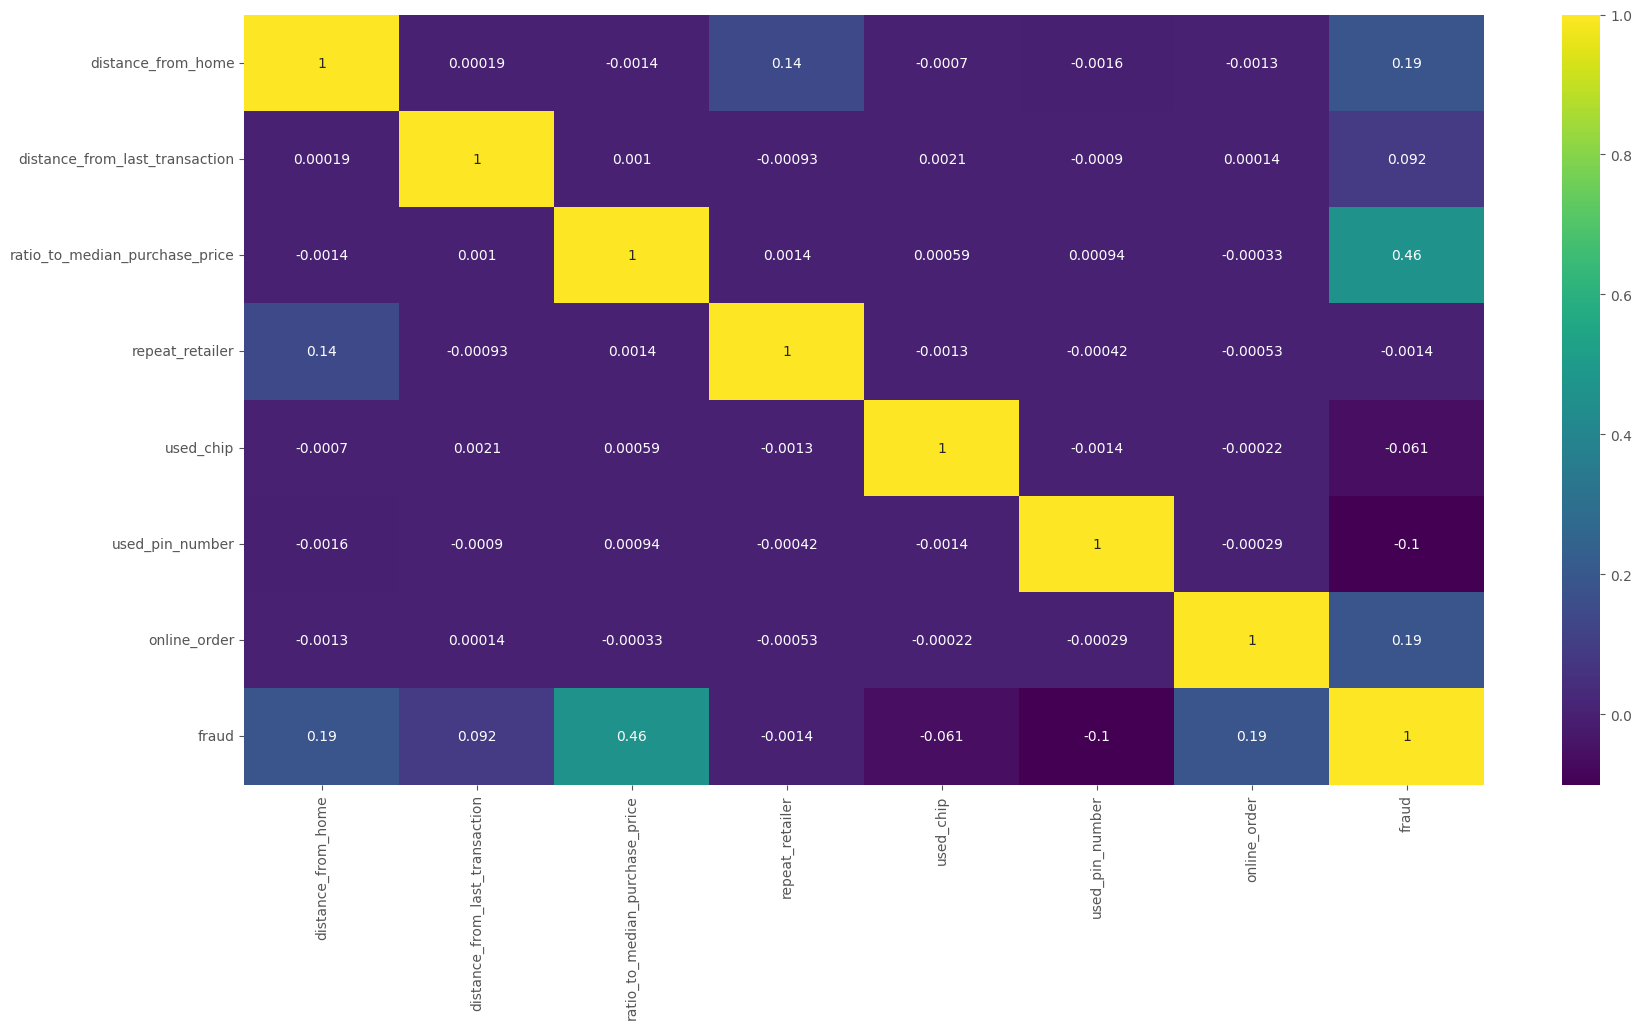

In [ ]:
# Heatmap to explain the correlation between the features
plt.figure(figsize = (20, 10))
sns.heatmap(data.corr(), annot = True, cmap='viridis')
plt.show()

This heatmap visualizes the correlation coefficients between various variables, providing insights into potential relationships within the data. Notably, the 'fraud' variable shows a moderate positive correlation with 'distance_from_home' and 'distance_from_last_transaction,' suggesting that transactions made further from home or the last transaction location may have a higher likelihood of being fraudulent. In contrast, there is a slight negative correlation between 'fraud' and the use of a chip or PIN ('used_chip' and 'used_pin_number'), implying that such security measures could reduce the risk of fraud. Additionally, there's a notable positive correlation between 'repeat_retailer' and 'online_order', indicating that repeat transactions are commonly made online.

However, many variables display very low to no linear correlation with one another, as indicated by the darker hues, pointing towards a lack of direct linear relationship.

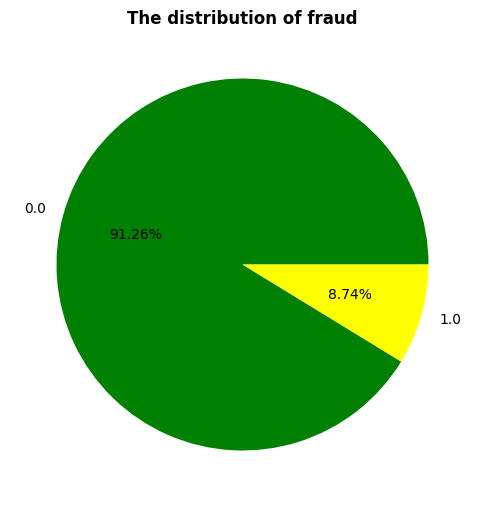

In [ ]:

plt.figure(figsize=(6, 8))
plt.pie(x=data['fraud'].value_counts().values,
        labels=data['fraud'].value_counts().index,
        autopct='%1.2f%%', colors=['green', 'yellow'])
plt.title('The distribution of fraud', size=12, weight='bold')
plt.show()

Given that 91.26% of the transactions are genuine, amounting to 912,597 instances, and only 8.74%, or 87,403 transactions, are fraudulent, it becomes clear that the dataset exhibits significant imbalance. To address this issue and enhance model performance, it would be prudent to employ techniques such as undersampling or oversampling. These strategies can help in balancing the distribution of the fraud variable, thereby providing a more equitable training ground for predictive modeling.

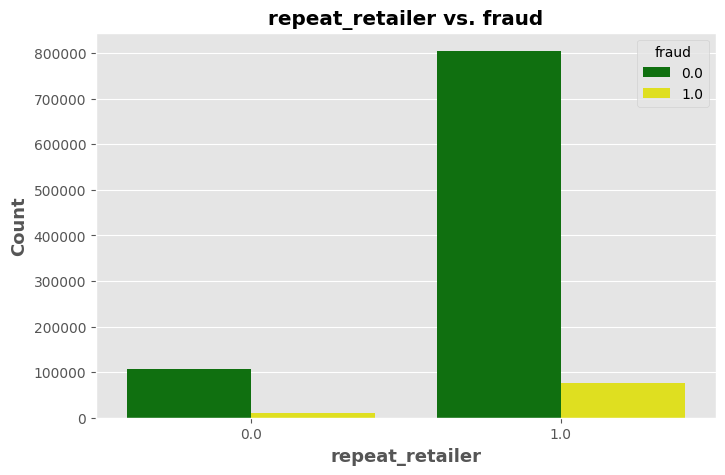

In [ ]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data,
              x = 'repeat_retailer',
              hue = 'fraud', palette=['green', 'yellow'])


# Add labels and title
plt.title('repeat_retailer vs. fraud', weight = 'bold')
plt.xlabel('repeat_retailer', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

This is show that the repeat_retailer is considered fraud

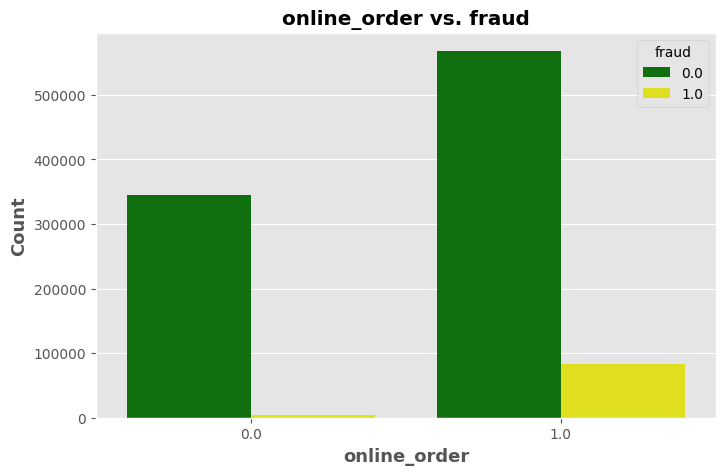

In [ ]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data,
              x = 'online_order',
              hue = 'fraud', palette=['green', 'yellow'])


# Add labels and title
plt.title('online_order vs. fraud', weight = 'bold')
plt.xlabel('online_order', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

This is show that fraud is more common in cases of online orders.

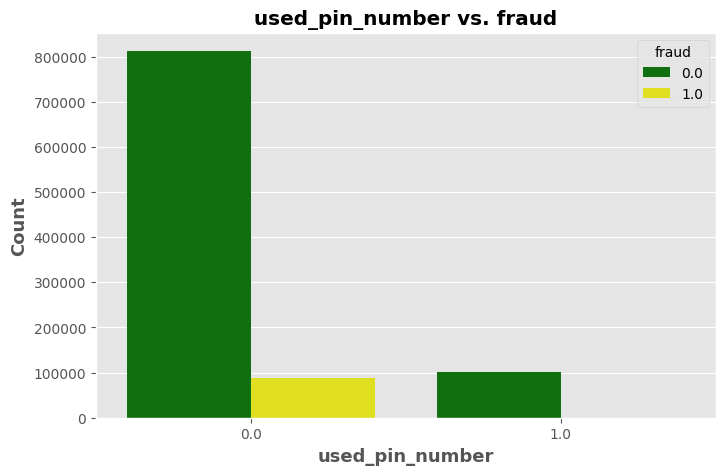

In [ ]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data,
              x = 'used_pin_number',
              hue = 'fraud', palette=['green', 'yellow'])


# Add labels and title
plt.title('used_pin_number vs. fraud', weight = 'bold')
plt.xlabel('used_pin_number', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

This is show that use the pin number is not usually considered a fraud.

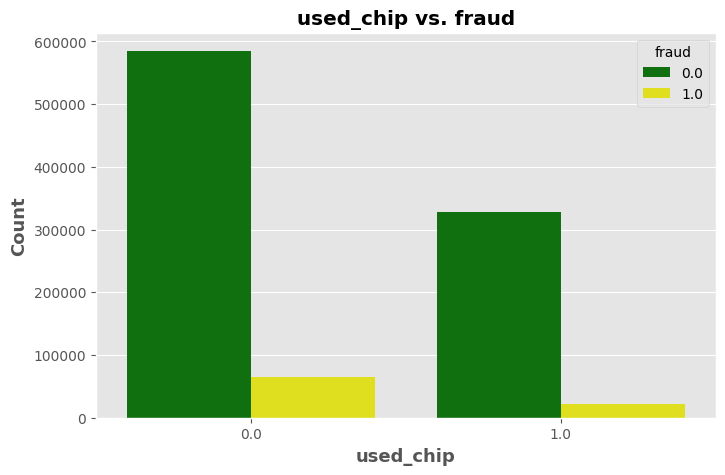

In [ ]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data,
              x = 'used_chip',
              hue = 'fraud', palette=['green', 'yellow'])


# Add labels and title
plt.title('used_chip vs. fraud', weight = 'bold')
plt.xlabel('used_chip', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

This is show that use the chip is not ususally used to fraud

**Part2: modeling**


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import numpy as np

# check if GPU is available
if torch.cuda.is_available():
    # get the GPU device name
    device_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(device_id)
    print(f"Using GPU: {device_id}, Name: {device_name}")
else:
    print("Using CPU device")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Load and prepare data
data = pd.read_csv('card_transdata.csv')
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1, 1)

# Normalize data
data_mean = np.mean(X, axis=0)
data_std = np.std(X, axis=0, ddof=1)
X_normalized = (X - data_mean) / data_std

# Convert to tensors (no device assignment here)
X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, Y_tensor, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(0.5),  # 50% probability of an element to be zeroed
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.5),  # Again, 50% dropout
            nn.Linear(64, output_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.network(x)

# DataLoader setup for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True if device == 'cuda' else False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True if device == 'cuda' else False)

# Initialize the neural network, loss function, and optimizer
nn_model = NeuralNetwork(X_train.shape[1]).to(device)
criterion = nn.BCELoss()#cost function
optimizer = optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization and adam optimizer


# Training loop with validation
epochs = 100
for epoch in range(epochs):
    nn_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = nn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    nn_model.eval()
    val_loss, val_accuracy = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = nn_model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_accuracy += ((outputs > 0.5) == labels).float().mean().item()
    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')

# Evaluation on the test set
nn_model.eval()
test_accuracy, f1 = 0, 0
with torch.no_grad():
    outputs = nn_model(X_test.to(device))
    predicted = (outputs > 0.5).float()
    test_accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
    f1 = f1_score(y_test.cpu().numpy(), predicted.cpu().numpy(), average='weighted')

print(f"Test Accuracy: {test_accuracy}\n F1 Score: {f1}")

Using GPU: 0, Name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design
Using cuda device
Epoch 0/100, Loss: 0.08717940002679825, Val Loss: 0.023383253294220193, Val Accuracy: 0.99282
Epoch 10/100, Loss: 0.005568617023527622, Val Loss: 0.013587385002705269, Val Accuracy: 0.99622
Epoch 20/100, Loss: 0.044493142515420914, Val Loss: 0.013403596439287067, Val Accuracy: 0.996015
Epoch 30/100, Loss: 0.1373840570449829, Val Loss: 0.013446833958551287, Val Accuracy: 0.996245
Epoch 40/100, Loss: 0.015761448070406914, Val Loss: 0.012987953155565774, Val Accuracy: 0.99609
Epoch 50/100, Loss: 0.008243035525083542, Val Loss: 0.013154971223390894, Val Accuracy: 0.996675
Epoch 60/100, Loss: 0.01361274253576994, Val Loss: 0.012105203485661187, Val Accuracy: 0.997135
Epoch 70/100, Loss: 0.01896064728498459, Val Loss: 0.010930461300666211, Val Accuracy: 0.99696
Epoch 80/100, Loss: 0.018740875646471977, Val Loss: 0.011991874363475945, Val Accuracy: 0.996665
Epoch 90/100, Loss: 0.020723413676023483, Val Loss: 0.

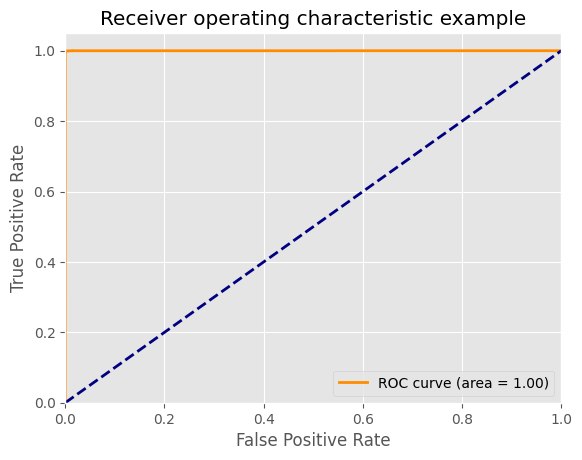

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# evaluate the model
nn_model.eval()
test_probs = []
with torch.no_grad():
    for inputs in X_test.to(device):
        outputs = nn_model(inputs.unsqueeze(0))  # Add a batch dimension
        test_probs.append(outputs.cpu().numpy())
test_probs = np.concatenate(test_probs, axis=0)

#  calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test.cpu(), test_probs)

# calculate the AUC
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


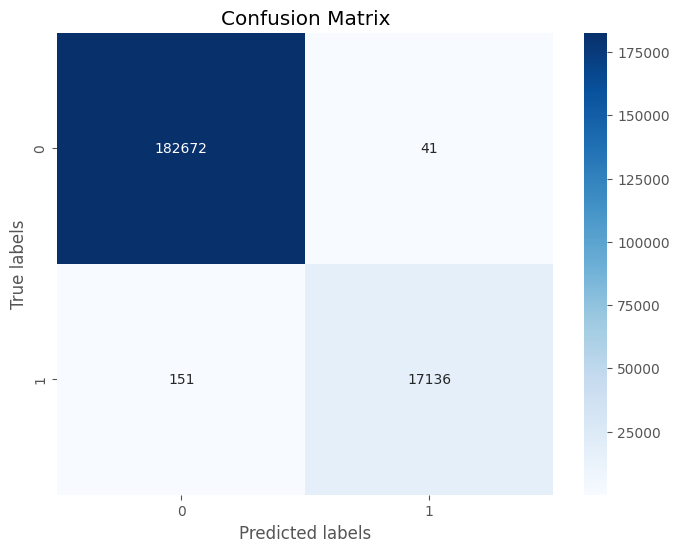

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = y_test.cpu().numpy()
y_pred = predicted.cpu().numpy()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()


This is show that the model is exellcent which  performance with an ROC curve AUC of 1.0. The confusion matrix reveals high accuracy with almost all negative samples correctly classified and a significant majority of positive samples correctly identified, indicative of a highly accurate model. Training logs show decreasing loss and consistently high validation accuracy over 100 epochs, demonstrating good learning. The final metrics, with a test accuracy of 99.626% and an F1 score of 0.9962, confirm the model's excellent performance on the test set

Task 3 (10 points): In task 2 describe how you selected the hyperparameters. What was the
rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use
an optimization algorithm? Why or why not?

In Task 2, the selection of hyperparameters was a strategic process guided by the aim to balance model complexity with the ability to generalize. The neural network's architecture incorporated 32 and 64 neurons in two hidden layers, chosen based on trial and error to capture the data's complexity without excessive computation. ReLU was employed as the activation function for its efficiency in deep networks, mitigating the vanishing gradient issue. Dropout with a rate of 0.5 served as regularization to prevent overfitting by randomly omitting units during training, ensuring the model learns robust features. Binary Cross-Entropy Loss was the chosen loss function, being standard for binary classification tasks. Adam optimizer was utilized for its adaptive learning rate benefits, which help navigate the parameter space more effectively. A learning rate of 0.001 and weight decay of 1e-5 were used to strike a balance between fast convergence and model simplicity, reducing overfitting risk. These hyperparameters and techniques were selected to enhance the model's learning from data while maintaining its generalization capabilities to new, unseen data. Regularization and an optimization algorithm were critical components of this strategy, chosen to optimize performance and mitigate common issues like overfitting.